# 利用信号处理和神经网络预测非平稳时间序列

"时序数据"和"时序信号"通常可以理解为相似的概念，但在一些上下文中可能会有细微的区别。这两个术语都描述了随时间变化的信息。

**时序数据**： 这个术语更通用，可用于描述按时间排序的任何数据。时序数据可以包括各种类型的信息，例如温度、股票价格、销售额、气象数据等。时序数据是一个广泛的范畴，可以表示任何以时间为基础的观测、记录或测量。

**时序信号**： 这个术语通常与信号处理领域相关，描述的是按时间顺序变化的信号。时序信号可能涉及到物理或工程领域中的传感器数据、音频信号、振动信号等。时序信号的处理通常涉及对信号的分析、滤波、频谱分解等操作。

在某些上下文中，这两个术语可能被互换使用，因为它们描述的实际上是相同的概念，即随时间变化的数据或信号。然而，具体的使用可能会根据领域和上下文而有所不同。**在信号处理、时间序列分析或机器学习等领域，这两个术语通常可以互换使用。**

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
from vmdpy import VMD # 加载VMD模块
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 变分模态分解(VMD)

### 分解特征

In [ ]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)

    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col]  # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [12]:
def auto_vmd(data: pd.DataFrame, columns: list, save_path, is_raw_output: bool = True, plots: bool = True) -> pd.DataFrame:
    """
    自动执行变分模态分解（VMD），对指定列进行模态分解，并动态选择最优的模态数K。

    参数:
    data (pd.DataFrame): 包含时间序列数据的数据框，索引应为时间戳或顺序索引。
    columns (list): 需要进行VMD分解的列名列表。
    save_path (str): 保存处理后数据的文件路径，若路径不存在会自动创建。
    is_raw_output (bool, 可选): 是否保留原始列，默认为True（保留原始列）。

    返回:
    pd.DataFrame: 处理后的数据框，包含VMD分解得到的模态列。
    """
    # 自动变分模态分解
    for col in columns:
        vmd_col_data = data[col].values.astype('float32')

        # 设置VMD参数
        signal = vmd_col_data 
        alpha = 500.0  # 数据保真性约束的平衡参数
        tau = 0.  # 对偶上升法的时间步长
        K_values = range(1, 11)  # 尝试不同的K值
        DC = True  # 第一个模态放置在直流分量
        init = 0  # 所有频率从0开始初始化
        tol = 1e-6  # 收敛标准的容差 
        
        # 记录能量损失
        energy_losses = []
        
        # 进行VMD分解并计算能量损失
        for K in K_values:
            u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
            
            # 计算每个模态的能量占总能量的比例
            energy = np.sum([np.sum(mode**2) for mode in u])
            total_energy = np.sum(signal**2)
            energy_loss = (1 - energy / total_energy) * 100
            energy_losses.append(energy_loss)

        # 选择能量损失最小的最优K值
        K = np.where(np.array(energy_losses) == np.array(energy_losses).min())[0][0] 
        
        # 执行最终的VMD分解
        u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol)  # 设置模态数目
        # u 是分解得到的模态
        # u_hat 是各模态的频谱
        # omega 是估计的模态中心频率

        # 绘制模态图
        if plots:
            plt.figure(figsize=(10, 6))
            plt.subplot(K + 1, 1, 1)
            plt.plot(data.index, vmd_col_data, label= col + '_原始信号')
            plt.legend()
            for i, mode in enumerate(u):
                plt.subplot(K + 1, 1, i + 2)
                plt.plot(data.index, mode, label=col + f'_模态 {i + 1}')
                plt.legend()
            plt.show()

        # 合并结果数据
        if u.shape[1] == len(data):
            index = data.index
        else:
            index = data.index[:-1]
        vmd_data = pd.DataFrame(u.T, index=index, columns=[col + '_mode_' + str(i) for i in range(1, K+1)])
        data = pd.concat([data, vmd_data], axis=1)

    # 是否需要输出原始列，默认输出
    if not is_raw_output:
        data = data.drop(columns, axis=1)
    data['时间'] = data.index
    
    # 设置保存模型路径
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    data.to_csv(save_path+"/vmd.csv", index=False)

    return data

In [13]:
data_path = "../data/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


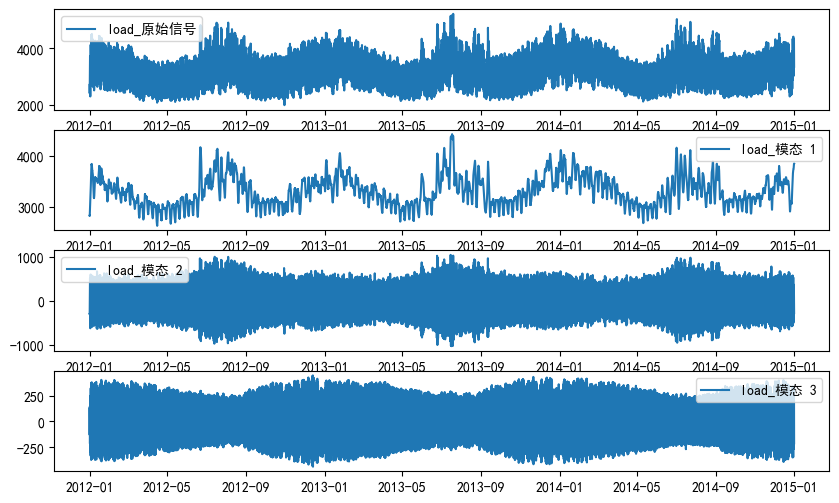

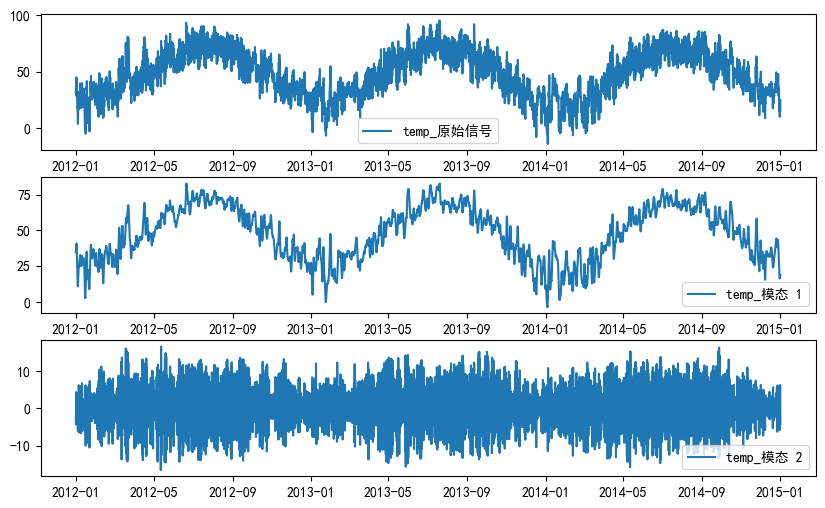

In [14]:
# 变分模态分解
params = {
    "data": ts_data,
    "columns": ['load', 'temp'],
    "save_path": "../outputs/datasets/Transformer",
    "is_raw_output": False,
    "plots": True
}
vmd_data = auto_vmd(**params)

In [7]:
vmd_data.columns

Index(['load_mode_1', 'load_mode_2', 'load_mode_3', 'temp_mode_1',
       'temp_mode_2', '时间'],
      dtype='object')

### 数据准备

In [11]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [19]:
# 数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    # 归一化
    x_scaler = MinMaxScaler()  # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list])
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    # 测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    # 验证集
    if train_ratio != 1:
        valid = df.copy().iloc[int(df.shape[0]*train_ratio)
                        : int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
        valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
        valid_stamp = valid_stamp.transpose(1, 0)
        valid[x_feature_list] = x_scaler.transform(valid)
        xva = valid.values.astype('float32')
        yva = df.copy().iloc[int(df.shape[0]*train_ratio)
                      : int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
        yva[y_feature_list] = y_scaler.transform(yva)
        yva = yva.values.astype('float32')
        valid = [xva, yva, valid_stamp]
    else:
        valid = [np.array(0), np.array(0), np.array(0)]

    # 测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]

    return x_scaler, y_scaler, train, valid, test

In [20]:
# 构造参数字典
params1 = {
    "df": data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'mode1', 'mode2', 'mode3'],
    "y_feature_list": ['temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/Transformer_vmd'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 4) y_train shape: (18412, 1) stamp_train shape: (18412, 4)
x_valid shape: (2631, 4) y_valid shape: (2631, 1) stamp_valid shape: (2631, 4)
x_test shape: (5261, 4) y_test shape: (5261, 1) stamp_test shape: (5261, 4)


In [21]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    stamp = data_list[2]  # 时间戳，不包含未来的时间

    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []

    for index in range(0, len(feature) - seq_len - pred_len + 1, sample_freq):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        # (终点 - 先验序列窗口)
        r_begin = s_end - label_len
        # (终点 + 预测序列长度)
        r_end = r_begin + label_len + pred_len

        # 数据维度
        feat = feature[s_begin: s_end]
        tar = target[r_begin: r_end]
        X.append(np.array(feat))
        y.append(np.array(tar))

        # 时间维度
        xs = stamp[s_begin: s_end]
        ys = stamp[r_begin: r_end]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))

    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()

    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(
        X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)

    return X, y, X_stamp, y_stamp, data_loader

In [22]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 1,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18404, 6, 4]),y_size: torch.Size([18404, 4, 1]),loader_len: 576
X_size: torch.Size([2623, 6, 4]),y_size: torch.Size([2623, 4, 1]),loader_len: 82
X_size: torch.Size([5253, 6, 4]),y_size: torch.Size([5253, 4, 1]),loader_len: 165


### 模型定义

In [23]:
# DataEmbedding编码类
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()
                    * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()
        
        # freq拆分
        number = re.findall('[0-9]', freq)
        number = 1 if len(number)==0 else int(''.join(number))
        string = re.findall('[a-z]', freq)[0]
        if string == 'h':
            hour_size = int(24 / number)
        elif string == 't':
            hour_size = 24
            minute_size = int(60 / number)
        elif string == 's':
            hour_size = 24
            minute_size = 60
            second_size = int(60 / number)
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        if freq == 's':
            self.second_embed = Embed(second_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        second_x = self.second_embed(x[:, :, 5]) if hasattr(
            self, 'second_embed') else 0.
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x + second_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6,
                    'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)
    
    
# Transformer_EncDec类
class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i == 0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns
    
    
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x
    
    
# 自编码类
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask
    
    
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return V.contiguous(), A
        else:
            return V.contiguous(), None
        
        
class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau=tau,
            delta=delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn
    
    
# Transformer模型
class Transformer(nn.Module):
    """
        embed: time features encoding, options:[timeF, fixed, learned]
        freq: 'freq for time features encoding, options:[s:secondly, 
            t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], 
            you can also use more detailed freq like 15min or 3h'
    """
    def __init__(self, seq_len, pred_len, label_len, output_attention, enc_in, d_model, dropout, factor, n_heads, d_ff, 
                e_layers, dec_in, d_layers, c_out, embed, freq):
        super(Transformer, self).__init__()
        self.pred_len = pred_len
        self.output_attention = output_attention
        # Embedding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=output_attention), d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu'
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        FullAttention(True, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    AttentionLayer(
                        FullAttention(False, factor, attention_dropout=dropout,
                                      output_attention=False),
                        d_model, n_heads),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation='relu',
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model),
            projection=nn.Linear(d_model, c_out, bias=True)
        )

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        # Embedding
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=None, cross_mask=None)
        
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

### 模型训练

In [24]:
def train(train_args, model_args):
    # 参数配置
    features = train_args['features']  # 模型预测模式
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len']  # 预测长度
    label_len = model_args['label_len']

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            with open(path + '/' + 'checkpoint.pth', 'wb') as f:
                torch.save(model.state_dict(), f)
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)  # 会用到实际数据
            batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if features == 'MS' else 0
            outputs = outputs[:, -pred_len:, f_dim:]
            batch_y = batch_y[:, -pred_len:, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)  # 会用到实际数据
                batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if features == 'MS' else 0
                outputs = outputs[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:]
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper')  # 绘制背景色
        plt.grid(axis='y', linewidth=0.35)  # 绘制网格
        plt.plot(val_losses, linestyle='-', color='#11b3b6')
        plt.plot(train_losses, linestyle='-', color='#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)

    return model

  5%|████▏                                                                              | 1/20 [00:43<13:45, 43.44s/it]

Epoch [1/20], Training Loss: 0.1549, Validation Loss: 0.0026
Validation loss decreased (inf --> 0.002579).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [01:38<15:01, 50.10s/it]

Epoch [2/20], Training Loss: 0.0034, Validation Loss: 0.0007
Validation loss decreased (0.002579 --> 0.000700).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [02:27<14:03, 49.63s/it]

Epoch [3/20], Training Loss: 0.0020, Validation Loss: 0.0034
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [03:15<13:04, 49.04s/it]

Epoch [4/20], Training Loss: 0.0015, Validation Loss: 0.0008
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [04:04<12:17, 49.17s/it]

Epoch [5/20], Training Loss: 0.0013, Validation Loss: 0.0007
Validation loss decreased (0.000700 --> 0.000692).  Saving model ...
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [04:55<11:33, 49.53s/it]

Epoch [6/20], Training Loss: 0.0012, Validation Loss: 0.0010
EarlyStopping counter: 1 out of 3
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [05:44<10:44, 49.55s/it]

Epoch [7/20], Training Loss: 0.0011, Validation Loss: 0.0007
EarlyStopping counter: 2 out of 3
Updating learning rate to 0.0007269952498697733


 35%|█████████████████████████████                                                      | 7/20 [07:04<13:07, 60.61s/it]

Epoch [8/20], Training Loss: 0.0011, Validation Loss: 0.0017
EarlyStopping counter: 3 out of 3
Early stopping!


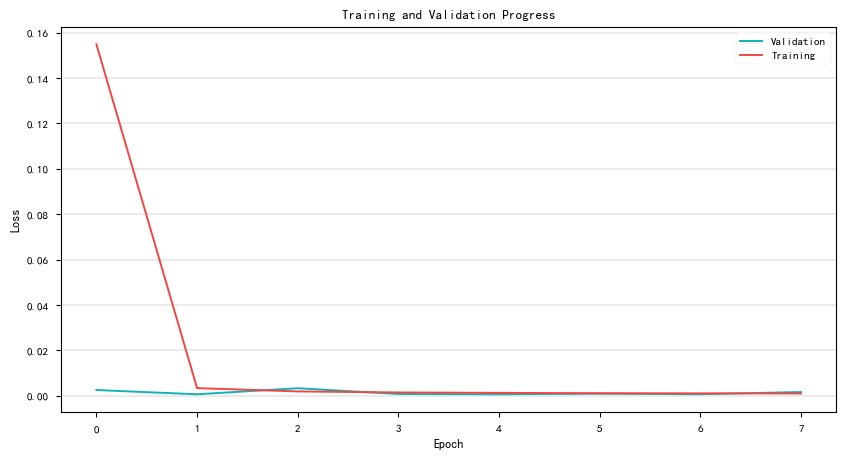

In [26]:
# 构造参数字典
params3 = {
    "train_args": {
        "features": 'M',
        "model_name": Transformer,
        "train_loader": train_loader,
        "valid_loader": valid_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.MSELoss(),
        "patience": 3,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/Transformer_vmd",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': 6,
        'pred_len': 3, 
        'label_len': 1,
        'output_attention': True,
        'embed': 'timeF', # 可选'timeF','fixed'和'learned'
        'freq': 'h',
        'd_model': 512,
        'enc_in': 4,
        'dec_in': 1,
        'dropout': 0.1,
        'factor': 3,
        'n_heads': 8,
        'd_ff': 128,
        'e_layers': 2,
        'd_layers': 2,
        'c_out': 1
    },
}
model = train(**params3)

## 经验模态分解(EMD)